# 並列計算しながら、大容量データを整理する方法

* 並列計算は、multiprocessing モジュールを使う
* 大容量データは、hdf5ファイルで管理する

[参考] https://github.com/h5py/h5py/blob/master/examples/multiprocessing_example.py

In [6]:
import multiprocessing as mp
import h5py

In [4]:
%matplotlib inline

# まず HDFファイルを使ってみる
* 乱数スペクトルを生成

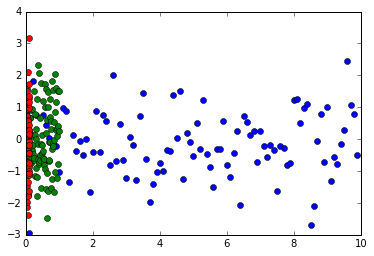

In [6]:
import numpy as np
import matplotlib.pyplot as plt
sampling_frequency = [10.,100.,1000.]
t= np.zeros((3,100))
sample= np.zeros((3,100))
for i in np.arange(3):
    t[i] = np.arange(0,100.,1)/sampling_frequency[i]
    sample[i] = np.random.normal(size=len(t[i]))
    plt.plot(t[i],sample[i],'o')

* FFTを実行

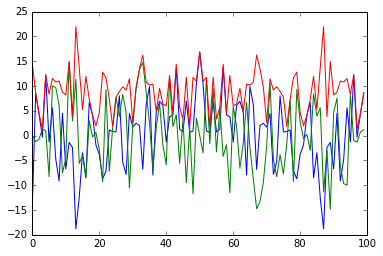

In [7]:
for i in np.arange(3):
    if i ==0:
        sample_fft =[np.fft.fft(sample[i])]
    else:
        sample_fft =np.r_[sample_fft,[np.fft.fft(sample[i])]]
plt.plot(np.real(sample_fft[0]))
plt.plot(np.imag(sample_fft[0]))
plt.plot(np.abs(sample_fft[0]))

In [49]:
import os
import h5py
output_file = "random.h5"
os.remove(output_file)
h5file = h5py.File(output_file,'w')
for i in np.arange(3):
    dir = 'frequency_'+str(np.int(sampling_frequency[i]))
    print (dir)
    h5file.create_group(dir)
    h5file.create_dataset(dir+'/random_number',data= sample[i])
    h5file.create_dataset(dir+'/spectrum',data= sample_fft[i])
    h5file.flush()
    
h5file.flush()
h5file.close()

frequency_10
frequency_100
frequency_1000


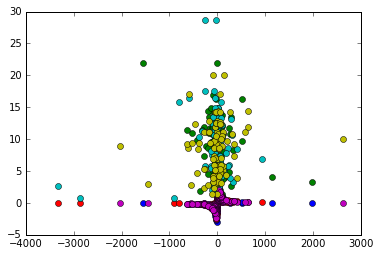

In [56]:
with h5py.File('random.h5','r') as hf:
    for i in np.arange(3):
        dir = 'frequency_'+str(np.int(sampling_frequency[i]))
        data1 = hf.get(dir+'/random_number',)
        data2 = hf.get(dir+'/spectrum',)
        np_data1 = np.array(data1)    
        np_data2 = np.array(data2)
        t[i] = np.arange(0,100.,1)/np_data1
        plt.plot(t[i],np_data1,'o')
        plt.plot(t[i],abs(np_data2),'o')
        

# pandasでCSV ファイルを読み込み　hdfに保存

A.txt
B.txt
[[1 2 3]
 [2 2 2]
 [0 4 5]
 [0 4 5]
 [0 4 1]
 [1 2 2]]


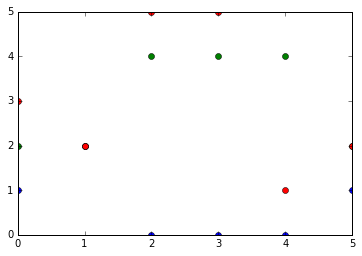

In [77]:
import pandas as pd
import glob,os

output_file = "xx.h5"
os.remove(output_file)
h5file = h5py.File(output_file,'w')

files = glob.glob('*.txt') 
gp='xx'
h5file.create_group(gp)
for fn in files:
    print (fn)
    df=pd.read_csv(fn)
    #h5file.create_dataset(gp+'/'+fn,data= np.array(df))
    h5file.create_dataset(gp+'/'+fn,data= df)
    h5file.flush()
h5file.close()

fn='A.txt'
with h5py.File(output_file,'r') as hf:
    data = hf.get(gp+'/'+fn)
    np_data = np.array(data)
    t = np.arange(0,len(np_data))
    print (np_data)
    plt.plot(t,np_data,'o')

---------------

# 並列処理のテスト

In [105]:
import numpy as np
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Creating 1-process pool
Creating output dataset with shape 512 x 512
Recording row 0
Recording row 25
Recording row 50
Recording row 75
Recording row 100
Recording row 125
Recording row 150
Recording row 175
Recording row 200
Recording row 225
Recording row 250
Recording row 275
Recording row 300
Recording row 325
Recording row 350
Recording row 375
Recording row 400
Recording row 425
Recording row 450
Recording row 475
Recording row 500
Closing HDF5 file
Shutting down process pool
Displaying fractal. Close window to exit program.


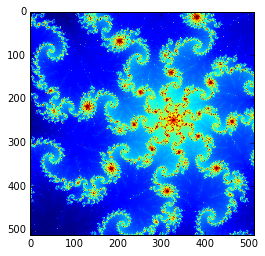

In [106]:
import multiprocessing as mp
import numpy as np
import os
# === Parameters for Mandelbrot calculation ===================================
NX = 512
NY = 512
ESCAPE = 1000

XSTART = -0.16070135 - 5e-8
YSTART =  1.0375665 -5e-8
XEXTENT = 1.0E-7
YEXTENT = 1.0E-7

xincr = XEXTENT*1.0/NX
yincr = YEXTENT*1.0/NY
#=== Functions to compute set ================================================
def compute_escape(pos):
    """ Compute the number of steps required to escape from a point on the
    complex plane """
    z = 0+0j;
    for i in range(ESCAPE):
        z = z**2 + pos
        if abs(z) > 2:
            break
    return i

def compute_row(xpos):
    """ Compute a 1-D array containing escape step counts for each y-position.
    """
    a = np.ndarray((NY,), dtype='i')
    for y in range(NY):
        pos = complex(XSTART,YSTART) + complex(xpos, y*yincr)
        a[y] = compute_escape(pos)
    return a

# === Functions to run process pool & visualize ===============================

def run_calculation():
    """ Begin multi-process calculation, and save to file """

    print("Creating %d-process pool" % mp.cpu_count())

    pool = mp.Pool(mp.cpu_count())
    fn_hdf='mandelbrot.hdf5'
    f = h5py.File(fn_hdf,'w')

    print("Creating output dataset with shape %s x %s" % (NX, NY))

    dset = f.create_dataset('mandelbrot', (NX,NY), 'i')
    dset.attrs['XSTART'] = XSTART
    dset.attrs['YSTART'] = YSTART
    dset.attrs['XEXTENT'] = XEXTENT
    dset.attrs['YEXTENT'] = YEXTENT
    
    result = pool.imap(compute_row, (x*xincr for x in np.arange(NX)))

    for idx, arr in enumerate(result):
        if idx%25 == 0: print("Recording row %s" % idx)
        dset[idx] = arr

    print("Closing HDF5 file")

    f.close()

    print("Shutting down process pool")

    pool.close()
    pool.join()

def visualize_file():
    """ Open the HDF5 file and display the result """
    try:
        import pylab as p
    except ImportError:
        print("Whoops! Matplotlib is required to view the fractal.")
        raise

    f = h5py.File('mandelbrot.hdf5','r')
    dset = f['mandelbrot']
    a = dset[...]
    p.imshow(a.transpose())

    print("Displaying fractal. Close window to exit program.")
    try:
        p.show()
    finally:
        f.close()

if __name__ == '__main__':
    fn_hdf='mandelbrot.hdf5'
    if os.path.isfile(fn_hdf):
        os.remove(fn_hdf)
    if not h5py.is_hdf5(fn_hdf):
        run_calculation()
    else:
        print('Fractal found in "mandelbrot.hdf5". Delete file to re-run calculation.')
    visualize_file()

In [13]:
import multiprocessing as mp
import numpy as np
import os


L = 20000
# 各プロセスが実行する計算
def subcalc(p): 
    subtotal = 0

    # iの範囲を設定
    ini = L * p / proc
    fin = L * (p+1) / proc

    # 計算を実行
    for i in range(ini, fin):
        for j in range(L):
            subtotal += i * j
    return subtotal

if __name__ == '__main__':
    # XX個のプロセスを用意
    pool = mp.Pool(mp.cpu_count())

    # 各プロセスに subcalc(p) を実行させる
    # ここで p = 0,1,...,7　callbackには各戻り値がlistとして格納される
    print (range(mp.cpu_count()))
    callback = pool.imap(subcalc, range(mp.cpu_count()))

    for idx, arr in enumerate(callback):
        print (arr)

    

range(0, 1)


TypeError: unsupported operand type(s) for /: 'int' and 'Pool'